In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def import_velocities(filename):
    t, vx, vy, vz = np.loadtxt(filename, unpack = True)
    return t, np.asarray([vx, vy, vz]).transpose()

In [3]:
def compute_vacf(velocities):
    N = len(velocities)
    vacf = np.zeros(N)
    for tau in range(N):
        print(f"step {tau}/{N}")
        dot_products = np.sum(velocities[:N - tau] * velocities[tau:], axis=1)
        vacf[tau] = np.mean(dot_products)
    return vacf

In [4]:
def compute_vacf_einsum(velocities):
    N = len(velocities)
    vacf = np.array([
        np.einsum('ij,ij->', velocities[:-tau], velocities[tau:]) / (N - tau)
        if tau > 0 else np.einsum('ij,ij->', velocities, velocities) / N
        for tau in range(N)
    ])
    return vacf / vacf[0]


In [5]:
def compute_vacf_fft(velocities):
    N = velocities.shape[0]
    
    # Flatten velocity vectors into 1D signals per component
    v = velocities.T  # Shape (3, N)

    # Compute VACF per component
    vacf_components = []
    for comp in v:
        # Zero-pad to 2N to avoid circular convolution
        f = np.fft.fft(comp, n=2*N) # compute frequency spectrum
        ps = f * np.conj(f) # compute power spectrum
        ac = np.fft.ifft(ps).real[:N]
        ac /= np.arange(N, 0, -1)  # Normalize by number of contributing terms
        vacf_components.append(ac)

    vacf = sum(vacf_components)  # Sum over x, y, z components
    return vacf / vacf[0]  # Optional: normalize

In [6]:
def compute_vacf_fft_precise(velocities):
    velocities = velocities.astype(np.float64)  # Ensure high precision
    N = velocities.shape[0]
    vacf_components = []

    # Zero-pad to next power of 2 ≥ 2N to avoid wrap-around effects
    pad = 2 ** int(np.ceil(np.log2(2 * N)))

    for d in range(3):  # x, y, z components
        v = velocities[:, d]
        v -= np.mean(v)  # Remove DC offset (mean)

        f = np.fft.fft(v, n=pad)
        ps = f * np.conj(f)
        ac = np.fft.ifft(ps).real[:N]

        ac /= np.arange(N, 0, -1)  # Normalize by N - τ
        vacf_components.append(ac)

    vacf = sum(vacf_components)
    vacf /= vacf[0]  # Normalize to VACF(0) = 1

    return vacf

In [7]:
from time import time

def time_func(func,*args, say = "Executed", **kwargs, ):
    start = time()
    returnvalue = func(*args, **kwargs)
    end = time()
    print(f"{say} in {end-start} seconds....")
    return returnvalue

loaded file in 2.1658806800842285 seconds....
Computed vacf in 0.17951226234436035 seconds....
loaded file in 1.7973833084106445 seconds....
Computed vacf in 0.14265108108520508 seconds....
loaded file in 1.8034029006958008 seconds....
Computed vacf in 0.1500389575958252 seconds....


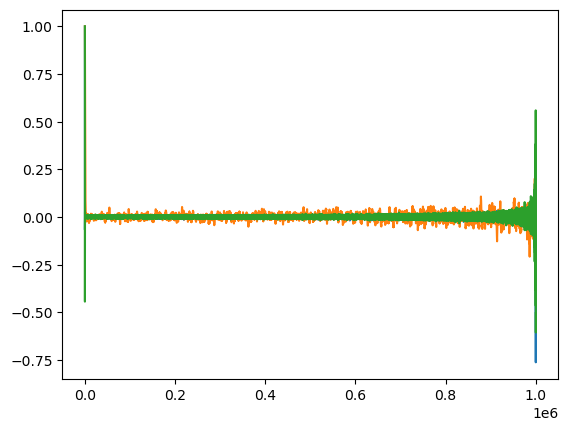

In [8]:

for i in [0,1,2]:
    t,v = time_func(import_velocities,  f"velocity_trajs/v_{i}.dat", say = "loaded file",)
    vacf = time_func(compute_vacf_fft, v, say = "Computed vacf")

    plt.plot(t, vacf)
    

In [9]:
def compute_D(t, vacf, cutoff = 1000):
    dt = np.diff(t)
    D = vacf[:cutoff] @ dt[:cutoff]

    return D

In [10]:
def compute_MSD(D, t):
    return 6*D*t

In [11]:
t0, v0 = import_velocities("velocity_trajs/v_0.dat")
t1, v1 = import_velocities("velocity_trajs/v_1.dat")
t2, v2 = import_velocities("velocity_trajs/v_2.dat")

Computed vacf in 0.17075586318969727 seconds....


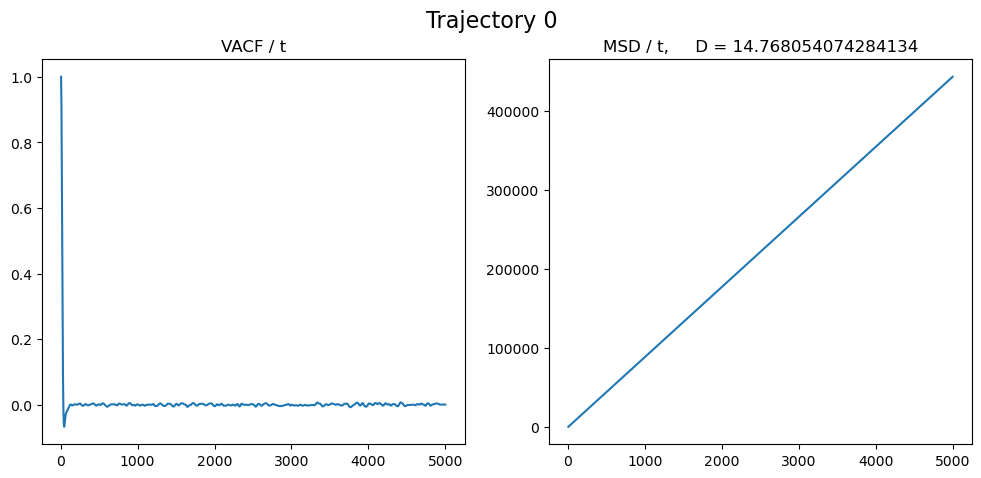

Computed vacf in 0.18660998344421387 seconds....


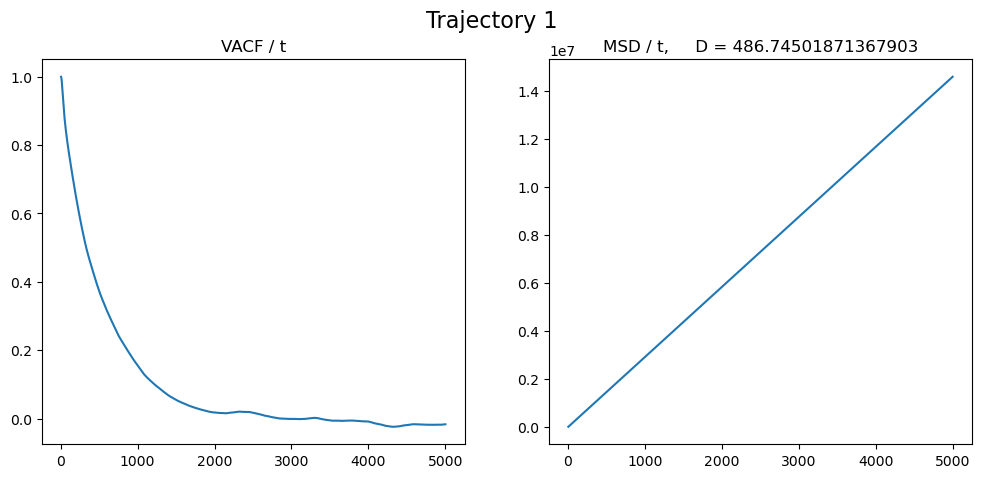

Computed vacf in 0.18394231796264648 seconds....


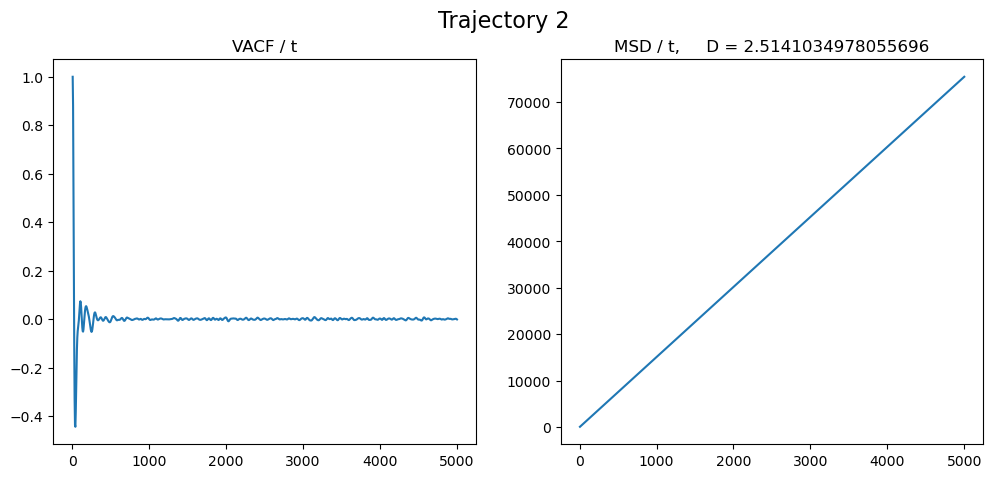

In [12]:
j = 0 # increments in loop

for i in [(t0, v0), (t1, v1), (t2, v2)]:
    t, v = i
    vacf = time_func(compute_vacf_fft, v, say = "Computed vacf")
    D = compute_D(t, vacf)
    MSD = compute_MSD(D, t)

    cutin = 0 # start
    cutoff = 1000 # end

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(t[cutin:cutoff], vacf[cutin:cutoff])
    axs[0].set_title("VACF / t")

    axs[1].plot(t[cutin:cutoff], MSD[cutin:cutoff])
    axs[1].set_title(f"MSD / t,     D = {D}")

    fig.suptitle(f"Trajectory {j}", fontsize = 16)
    plt.show()

    j += 1

